# Import Basic Libraries

In [2]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson, expon
from tqdm import tqdm
import random

%matplotlib inline

In [3]:
graph = nx.read_gpickle("graph.pkl")

# Basic Properties of the Network

In [6]:
# number of nodes and edges
n, m = graph.number_of_nodes(), graph.number_of_edges()
print(f"Num nodes: {n}, Num edges: {m}")

# connected components
connected_components = nx.connected_components(graph)
subgraphs = [graph.subgraph(c) for c in connected_components]
print(f"Num connected components: {len(subgraphs)}")
for subgraph in subgraphs:
    num_nodes = subgraph.number_of_nodes()
    print(f"Num nodes in component: {num_nodes}")


Num nodes: 10397, Num edges: 15823
Num connected components: 2
Num nodes in component: 10390
Num nodes in component: 7


In [9]:
# largest connected component
large_subgraph = max(subgraphs, key=lambda x: x.number_of_nodes())
small_subgraph = min(subgraphs, key=lambda x: x.number_of_nodes())
# TODO: diameter
# diameter = nx.diameter(largest_subgraph)
# print(f"Diameter of largest connected component: {diameter}")

In [13]:
# mean degree
mean_degree = np.mean(list(dict(graph.degree()).values()))
mean_degree_square = np.mean([degree**2 for degree in dict(graph.degree()).values()])
print(f"Mean degree: {mean_degree}, Mean degree squared: {mean_degree_square}")

# max degree
max_degree = max(dict(graph.degree()).values())
print(f"Max degree: {max_degree}")

Mean degree: 3.043762623833798, Mean degree squared: 12.39761469654708
Max degree: 19


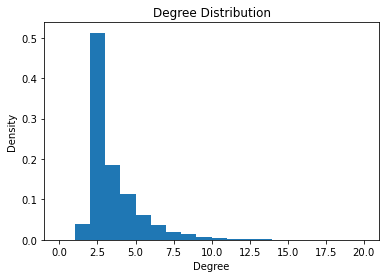

In [14]:
# degree distribution
def degree_distribution_plot(graph):
    degrees = [graph.degree(node) for node in graph.nodes()]
    plt.hist(degrees, bins=np.arange(0, 21), density=True)
    plt.xlabel("Degree")
    plt.ylabel("Density")
    plt.title("Degree Distribution")
    plt.show()

degree_distribution_plot(graph)

p in ER graph: 0.0002927820915576951


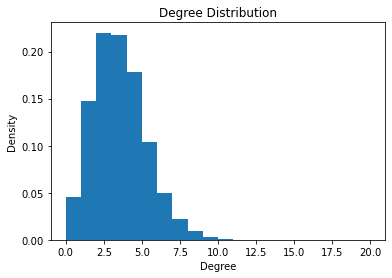

In [15]:
# compare with Erdos-Renyi Graph
p = mean_degree / (n-1)
print(f"p in ER graph: {p}")

ER_graph = nx.erdos_renyi_graph(n, p)
degree_distribution_plot(ER_graph)

In [16]:
# clustering coefficient
clustering_coef = nx.average_clustering(graph)
print(f"Clustering coefficient: {clustering_coef}")

Clustering coefficient: 0.13668278073790174


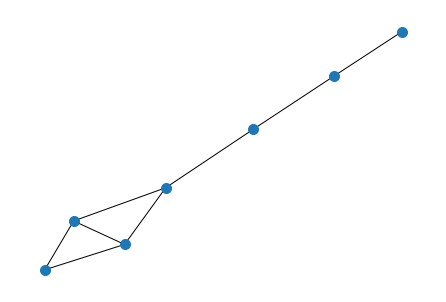

In [19]:
# plot the smaller component
pos = nx.spring_layout(small_subgraph, iterations=100)
nx.draw(small_subgraph, pos, with_labels=False, node_size=100, font_size=8)
plt.show()

# Network Centrality

In [31]:
def get_centrality(graph):
    centrality_dict = {}
    centrality_dict['degree'] = nx.degree_centrality(graph)
    centrality_dict['closeness'] = nx.betweenness_centrality(graph, k=1000)
    centrality_dict['pagerank'] = nx.pagerank(graph)
    return centrality_dict

In [32]:
centrality_dict = get_centrality(graph)

In [35]:
# get nodes with highest centrality score
def get_top_k_nodes(centrality_dict, k):
    top_k_nodes = {}
    for key in centrality_dict:
        top_k_nodes[key] = sorted(centrality_dict[key].items(), key=lambda x: x[1], reverse=True)[:k]
    return top_k_nodes

top_k_nodes = get_top_k_nodes(centrality_dict, k=5)
for key in centrality_dict:
    print(f"Measure: {key}")
    for node in top_k_nodes[key]:
        print(node)

Measure: degree
('北太平桥西', 0.0018276260100038477)
('六里桥北里', 0.0018276260100038477)
('十里河桥北', 0.0017314351673720662)
('祁家豁子', 0.0017314351673720662)
('马甸桥南', 0.001635244324740285)
Measure: closeness
('安贞桥西', 0.2543759234318632)
('马甸桥东', 0.25215972313497736)
('六里桥北里', 0.24900927905110767)
('北太平桥西', 0.21710966221393307)
('静安庄西', 0.2038844148119012)
Measure: pagerank
('六里桥北里', 0.00032836694117787524)
('十里河桥北', 0.0003209063290672097)
('北太平桥西', 0.0003177352798265052)
('地铁经海路站', 0.00031718695957926924)
('开发区交通服务中心', 0.0003164316402437036)


In [40]:
node = "五道口"
for key in centrality_dict:
    print(f"Measure: {key}")
    print(f"{centrality_dict[key][node]}")

Measure: degree
0.0006733358984224703
Measure: closeness
0.0006318066881450264
Measure: pagerank
0.00016983677268245985


# shortest path & small-world phenomenon

In [42]:
source, target = "五道口", "天安门东"
shortest_path = nx.shortest_path(graph, source=source, target=target)
print(shortest_path)
print(len(shortest_path))

['五道口', '北京语言大学', '成府路口南', '北京航空航天大学', '蓟门桥南', '明光桥南', '西直门南', '阜成门北', '北京儿童医院', '南礼士路', '复兴门内', '西单路口东', '天安门西', '天安门东']
14


In [52]:
# average distance between nodes
num_nodes = 1000
node_samples = random.sample(large_subgraph.nodes(), num_nodes)
shortest_path_lengths = sum(l for u in node_samples for l in nx.single_source_shortest_path_length(large_subgraph, u).values())
average_distance = shortest_path_lengths / (num_nodes * (large_subgraph.number_of_nodes()-1))
average_distance

29.097305611704687

# Robustness

In [ ]:
# robustness: randomly remove nodes and see how the size of the largest connected component changes
def random_node_deletion_experiment(G, num_iterations=10, end=1000, step=1):
    results = []
    for i in tqdm(range(1, end, step)):
        max_connected_components = []
        for _ in range(num_iterations):
            H = G.copy()
            nodes_to_remove = random.sample(H.nodes(), i)
            H.remove_nodes_from(nodes_to_remove)
            connected_components = list(nx.connected_components(H))
            if connected_components:
                max_connected_components.append(max(map(len, connected_components)))
            else:
                max_connected_components.append(0)
        average_max_connected_component = sum(max_connected_components) / num_iterations
        results.append(average_max_connected_component)
    return results

result = random_node_deletion_experiment(graph, num_iterations=5, end=8000, step=5)
x = np.arange(1, 8000, 5)
plt.plot(x, result)

In [ ]:
def attack_sequential_deletion_experiment(graph, end=8000, step=1):
    # delete nodes with highest degree sequentially
    results = []
    graph = graph.copy()
    for _ in tqdm(range(1, end, step)):
        nodes_to_remove = sorted(graph.nodes(), key=graph.degree, reverse=True)[:step]
        graph.remove_nodes_from(nodes_to_remove)
        connected_components = list(nx.connected_components(graph))
        results.append(max(map(len, connected_components)))
    return results

result = attack_sequential_deletion_experiment(graph, end=8000, step=5)
plt.plot(x, result)

In [61]:
# Molly-Reed Criterion
fc = 1 - 1.0 / (mean_degree_square / mean_degree - 1)
fc

0.6745979517130753